# Group Project

*   LSTM
*   dataset - https://ga-data-cases.s3.eu-central-1.amazonaws.com/pump_sensor.zip
*   predictive maintenance for pump sensor data


In [1]:
import sys
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from math import sqrt
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Sklearn: {}'.format(sklearn.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))

import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

Python: 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
Pandas: 1.5.3
Numpy: 1.23.5
Sklearn: 1.2.1
Matplotlib: 3.7.0


In [2]:
def manipulate_X(data, printplot=False):
    
    data=data.drop(labels=['sensor_15'],axis=1) # bad sensors
    data=data.drop(labels=['sensor_00'],axis=1) # bad sensors

    data.loc[110000:140000, 'sensor_51'] = data.loc[110000:140000, 'sensor_50'] # repair sensor 51
    data=data.drop(labels=['sensor_50'],axis=1) # bad sensors

    data=data.drop(labels=['sensor_06','sensor_07','sensor_08','sensor_09'],axis=1) # low varianz NaNs
    data=data.fillna(method="pad",limit=30) # fill missing values with last known value
    data=data.dropna()
    if printplot==True:
        print((data.isna().sum()))
        plotting_stuff((data.isna().sum()[2:-1]),'bar','Sensors', 'Null Value', 'After Manipulate Data')

    return data

In [3]:
def plotting_stuff(data, plottype, x_name, y_name, Title):
    
    fig=plt.figure()
    data.plot(kind = plottype)

    plt.xlabel(x_name, size=14)
    plt.ylabel(y_name, size=14)
    plt.title(Title)

In [4]:
def plotting_together(Values):
    
    fig=plt.Figure()
    Values.plot(subplots = True, sharex = True, figsize=(30,55))

    plt.xlabel('Timesteps', size=20)
    plt.show()

In [5]:
# Plot target variable
def plot_Y(data, col='target'):
    
    y = data[col]; x = np.linspace(1,len(y),len(y))
    plt.plot(x,y)
    plt.xlabel('Timesteps')
    plt.ylabel('Class')
    plt.title('Target Variable')
    labels = ['Normal','Broken','Recovering'] # Give the y-axis the Class labels
    if col=='target':
        plt.yticks([1,0,2], labels, rotation='vertical')
    elif col=='machine_status':
        plt.yticks([0,1,2], labels, rotation='vertical')

    plt.show()

In [6]:
# Convert the classes from string to values by using scikit-learn mapper
def preprocess_labels(data):

    # Label Mapping
    le = preprocessing.LabelEncoder() # get the label encoder
    le.fit(data) # fit it to the data that the encoder knows what to do
    encoded_y=le.transform(data) # transform the data and put into a pandas data frame
    
    # Get the Label map
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_))) # to be able to later identify what is what, create a label map
    print(le_name_mapping)
    
    return pd.DataFrame(encoded_y,columns=['target'])

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('sensor%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('sensor%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('sensor%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together in a DataFrame
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with NaN values created by the shift
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [8]:
def splitting_and_shape_data(data_x,data_y):    
    train_X=data_x[0:120000].values
    train_Y=data_y[0:120000].values
    
    val_X=data_x[140000::].values
    val_Y=data_y[140000::].values
    
    test_X=data_x[120000:140000].values
    test_Y=data_y[120000:140000].values
      
    train_X.astype('float32')
    val_X.astype('float32')
    test_X.astype('float32')
    
    return train_X,train_Y,val_X,val_Y,test_X,test_Y

In [9]:
# one hot encode the targets for class prediction/ not for signal prediction
def one_hot(train_Y,val_Y,test_Y):
    
    from sklearn.preprocessing import OneHotEncoder

    oneHot = OneHotEncoder()
    oneHot.fit(train_Y.reshape(-1,1))

    train_Y_Hot=oneHot.transform(train_Y.reshape(-1,1)).toarray()
    val_Y_Hot  =oneHot.transform(val_Y.reshape(-1,1)).toarray()
    test_Y_Hot =oneHot.transform(test_Y.reshape(-1,1)).toarray()

    return train_Y_Hot,val_Y_Hot,test_Y_Hot

In [10]:
# Reshape the data for LSTM
def reshape_for_Lstm(data):
    
    # reshape for input
    timesteps=1
    samples=int(np.floor(data.shape[0]/timesteps))

    data=data.reshape((samples,timesteps,data.shape[1]))   # samples, timesteps, sensors
    return data

In [11]:
def LSTM_model_setup(in_shape):
   
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.layers import Dense

    inputs = tf.keras.Input(shape = (in_shape[1], in_shape[2]))
    x = LSTM(42, activation = 'relu', input_shape = (in_shape[1],in_shape[2]),return_sequences = True)(inputs)
    x = LSTM(42, activation = 'relu')(x)
    out_signal = Dense(1, name = 'signal_out')(x)
    out_class = Dense(3, activation = 'softmax', name = 'class_out')(x)

    model = tf.keras.Model(inputs = inputs, outputs = [out_signal,out_class])

    model.compile(loss = {'signal_out':'mean_squared_error',
                        'class_out' :'categorical_crossentropy'},
                         optimizer = 'adam',
                         metrics = {'class_out':'acc'})

    print(model.summary())
    return model

In [12]:
def plot_training(history,what='loss', name='training'):
    
    fig=plt.figure()
    plt.plot(history[0])
    plt.plot(history[1])
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    if what=='loss':
        plt.title('model loss')
        plt.ylabel('loss')
    elif what=='acc':
        plt.title('model Acc')
        plt.ylabel('Accuracy')


    plt.xlabel('epoch')
    plt.legend(['train', 'test'])

    plt.show()

In [13]:
def plot_predicted_results(Y_test, Y_predicted):
   
    fig= plt.figure()
    plt.plot(Y_predicted)
    plt.plot(Y_test)
    plt.legend(['target','target_predicted'])
    plt.ylabel('Class')
    plt.xlabel('Timesteps')
    plt.title('Prediction on test data')
    
    # Set the y-axis ticks and labels
    labels = ['Recovering', 'Normal', 'Broken']
    plt.yticks([2, 1, 0], labels, rotation='vertical')

    plt.show()

In [14]:
# LOAD DATA
df = pd.read_csv('pump_sensor.csv')

sensorname = df.keys()[2:-1]

# Print 1st 5 rows
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


From the timestamp, we can see that the
data is recorded in 1-minute steps in the yyyy-MM-dd HH:mm:ss format. The sensor data is in float32 with varying amplitude

In [15]:
print('Data overview: ')
print(df.shape)

Data overview: 
(220320, 55)


In [16]:
print('keys :') ; print(df.keys())

keys :
Index(['Unnamed: 0', 'timestamp', 'sensor_00', 'sensor_01', 'sensor_02',
       'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07',
       'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12',
       'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17',
       'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22',
       'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27',
       'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32',
       'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37',
       'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42',
       'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47',
       'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')


The data is separated into 52 sensor columns, one machine status (target/results) column, a timestamp column, and one Unnamed column, which is just the original index column.

Get the unique classes and see how many values we have for each class. Will convert them into corresponding integer values later using a mapper function from scikit-learn.

In [17]:
print( 'status options: ');  print( df['machine_status'].unique())

status options: 
['NORMAL' 'BROKEN' 'RECOVERING']


In [18]:
print (df['machine_status'].value_counts())

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64


We have the majority class “Normal”.

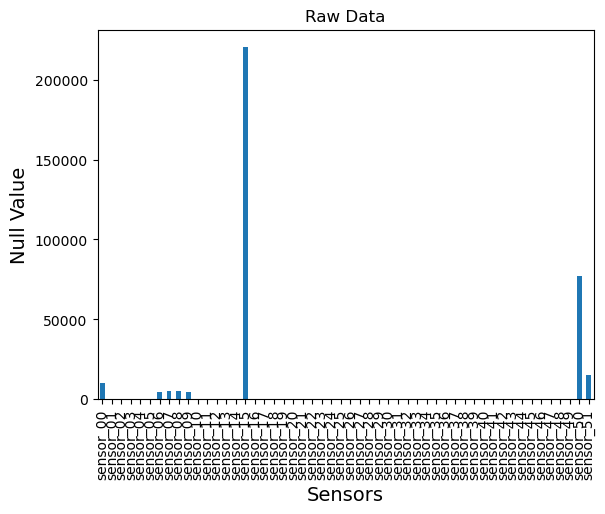

In [19]:
plotting_stuff((df.isna().sum())[2:-1],'bar', 'Sensors', 'Null Value', 'Raw Data') # show which sensors have how many NANs

So we first check, print and plot NaNs as they are. We notice right away, that Sensor_15 is completely empty, so we remove him to scale the data better.

Unnamed: 0        0
timestamp         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0
sensor_48         0
sensor_49         0
sensor_51         0
machine_status    0
dtype: int64


,Unnamed: 0,timestamp,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_10,sensor_11,sensor_12,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,0,2018-04-01 00:00:00,47.09201,53.211800,46.310760,634.375000,76.45975,37.22740,47.52422,31.11716,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
1,1,2018-04-01 00:01:00,47.09201,53.211800,46.310760,634.375000,76.45975,37.22740,47.52422,31.11716,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
2,2,2018-04-01 00:02:00,47.35243,53.211800,46.397570,638.888900,73.54598,37.86777,48.17723,32.08894,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,NORMAL
3,3,2018-04-01 00:03:00,47.09201,53.168400,46.397568,628.125000,76.98898,38.57977,48.65607,31.67221,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,NORMAL
4,4,2018-04-01 00:04:00,47.13541,53.211800,46.397568,636.458300,76.58897,39.48939,49.06298,31.95202,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,220315,2018-08-31 23:55:00,47.69965,50.520830,43.142361,634.722229,64.59095,43.17085,54.16052,38.05424,...,30.208330,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,231.1921,NORMAL
220316,220316,2018-08-31 23:56:00,47.69965,50.564240,43.142361,630.902771,65.83363,43.21038,54.52602,38.53485,...,29.947920,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,231.1921,NORMAL
220317,220317,2018-08-31 23:57:00,47.69965,50.520830,43.142361,625.925903,67.29445,43.12836,55.11779,38.52678,...,30.208330,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,232.0602,NORMAL
220318,220318,2018-08-31 23:58:00,47.69965,50.520832,43.142361,635.648100,65.09175,42.35746,55.99321,38.89159,...,30.208332,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,234.0856,NORMAL


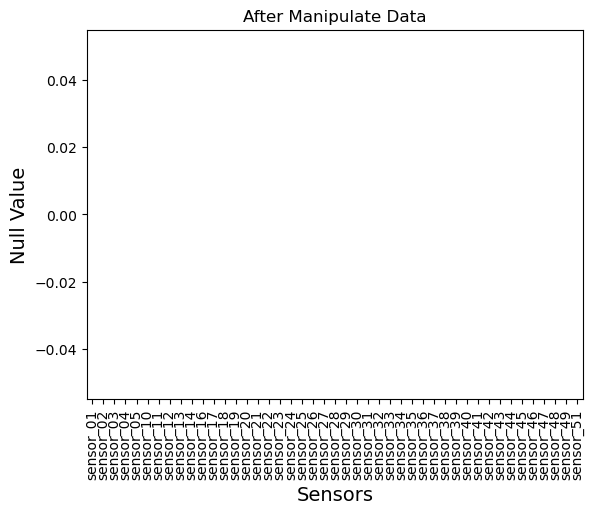

In [20]:
manipulate_X(df, printplot=True)

In [21]:
# MAP TARGETS TO VALUE
encoded_y = preprocess_labels(df['machine_status']);

{'BROKEN': 0, 'NORMAL': 1, 'RECOVERING': 2}


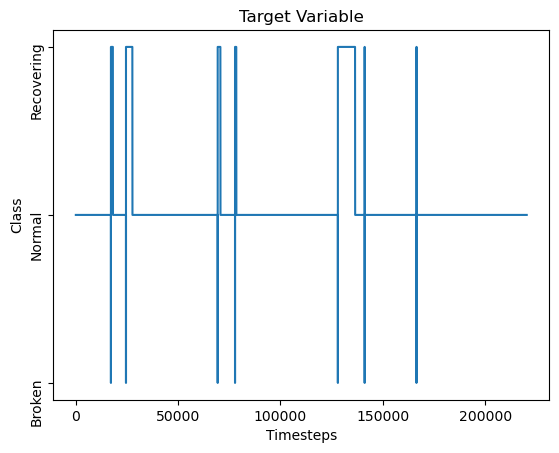

In [22]:
plot_Y(encoded_y, col='target')

We can see that the Revovering class always follows the Broken class. This means that it is not a problem to have only 7 entries for the Broken class, as we just have to predict the recovering phase to also get the Broken class.

We have one entry for each row, resulting in a one-machine:many-sensors supervised learning task.

In [23]:
Values = pd.concat([df[sensorname], encoded_y], axis=1)

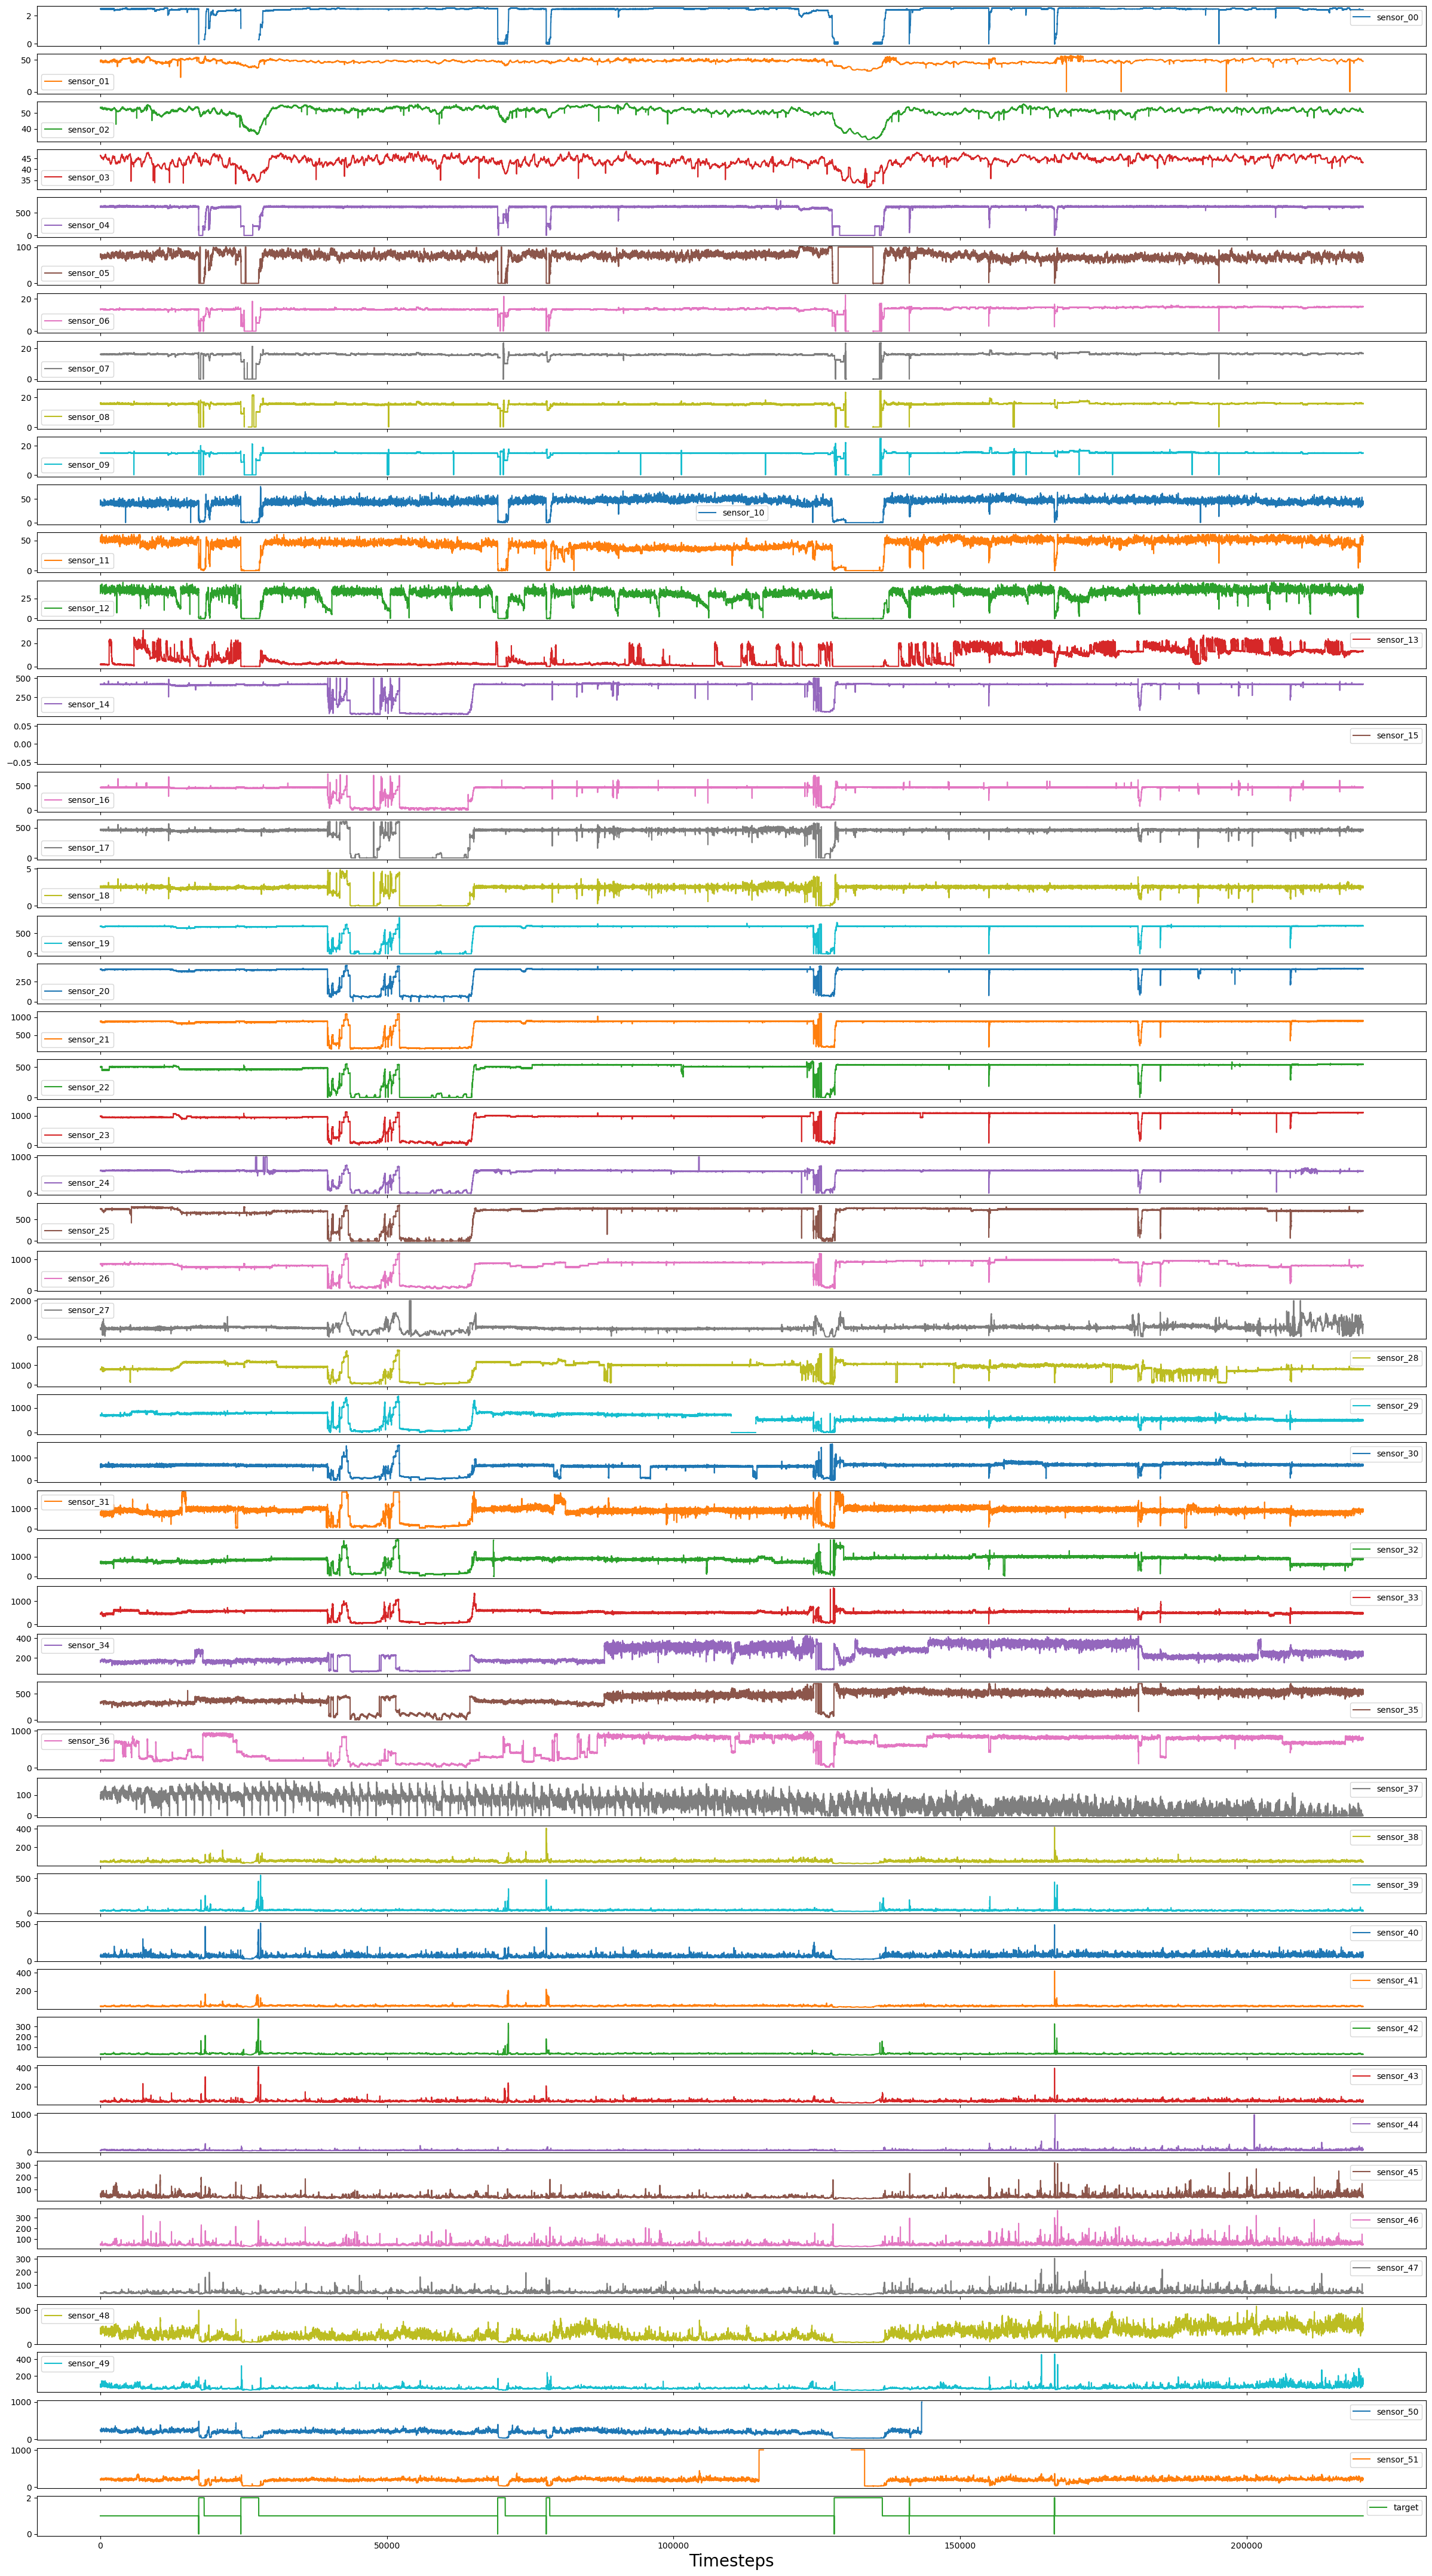

In [24]:
plotting_together(Values) # plot all signals together with target

We can see that there are sets of sensors that look very similar to each other.

As we did no feature selection, we should use either a random forest classifier/predictor or a type of ANN, as both works as an integrated feature selector. We choose an LSTM to later test its support on the embedded hardware.

We want to predict future classes based on the actual values. Hence, we need to shift the data against the target to create a time gap.

In [25]:
#PREPROCESS DATA
Values=manipulate_X(Values, printplot=False); sensorname=Values.keys()[:-1]

In [26]:
# CREATE WINDOWED DATA
Future = 1 # How many steps to look into the future

data_win = series_to_supervised(Values, n_in = Future, n_out = 1) # Create shifted data
to_remove_list = ['sensor'+str(n)+'(t)' for n in range(1,len(Values.columns)+1)] # now remove all non shifted elements again. So we retreive elements and shifted target

data_y = data_win.iloc[:,-1] # Get the target data out before removing unwanted data
data_x = data_win.drop(to_remove_list, axis = 1) # remove sensors(t)
data_x.drop(data_x.columns[len(data_x.columns)-1], axis = 1, inplace = True) # remove target(t-n)

We will be left with desired shifted data and unshifted target.

In [27]:
# CREATE TRAIN/VAL/TEST SETS
# We split the data that all sets have at least one error in. But shuffeling is not allowed. Therefore, we do it manually.

train_X, train_Y, val_X, val_Y, test_X, test_Y = splitting_and_shape_data(data_x, data_y)

As we are looking for classification, we have to one-hot-encode our target before training so the softmax activation interprets the classes correctly without misinterpreting the class order (0,1,2) as ranking or importance.

In [28]:
train_Y_Hot,val_Y_Hot,test_Y_Hot = one_hot(train_Y,val_Y,test_Y)

In [29]:
# NORMALIZATION - SCALE THE LSTM SETS BETWEEN 0-1 FOR NEUTRAL COMPARISON

scaler = MinMaxScaler().fit(train_X)
train_X = scaler.transform(train_X)

scaler = MinMaxScaler().fit(val_X)
val_X = scaler.transform(val_X)

scaler = MinMaxScaler().fit(test_X)
test_X = scaler.transform(test_X)

In [30]:
import xgboost as xgb
import joblib
import numpy as np

seed = 4353

# Reshape the input data for XGBoost
train_X_xgb = np.reshape(train_X, (train_X.shape[0], -1))
val_X_xgb = np.reshape(val_X, (val_X.shape[0], -1))
test_X_xgb = np.reshape(test_X, (test_X.shape[0], -1))

# Define train_Y_xgb (replace this with your actual target variable)
train_Y_xgb = train_Y

# Instantiate and fit the XGBoost model
xgb_ = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    nthread=4,
    scale_pos_weight=1,
    seed=seed
)

xgb_.fit(train_X_xgb, train_Y_xgb)

# Make predictions
predictions = xgb_.predict(test_X_xgb)

# Save the model
joblib.dump(xgb_, 'model.pkl')

[08:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



['model.pkl']

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.92      0.97      0.94     11609
           2       0.95      0.88      0.91      8390

    accuracy                           0.93     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.93      0.93      0.93     20000

[[    0     0     1]
 [    0 11228   381]
 [    0  1006  7384]]
Accuracy:  93.06 %
F1-score:  0.93


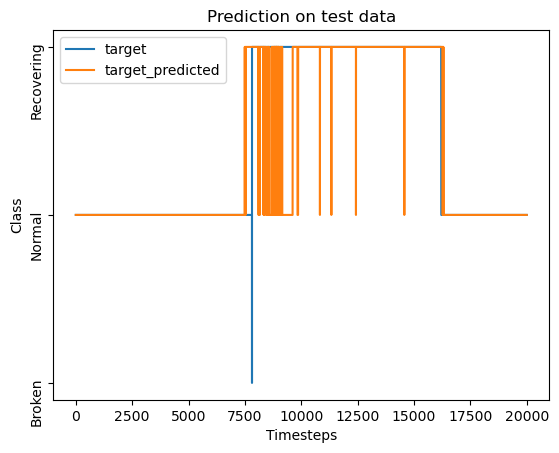

In [31]:
# Model evaluation
print(classification_report(test_Y, predictions, zero_division=0))
print(confusion_matrix(test_Y, predictions))

xgb_f1 = round(f1_score(test_Y, predictions, average='weighted'), 3)
xgb_accuracy = round((accuracy_score(test_Y, predictions) * 100), 2)

print("Accuracy: ", xgb_accuracy, "%")
print("F1-score: ", xgb_f1)

# Plot predicted results
plot_predicted_results(predictions, test_Y)

More LSTM layers provide different scaling in time, hence better time resolution/better performance. In LSTMs, the number of memory cells is less important than the number of layers in regard to analyzing time series. The rule of thumb here is fewer hidden units (memory cells) than input features.

In [32]:
# RESHAPE THE DATA TO FIT LSTMs FORMAT [samples, timesteps, sensors]

train_X = reshape_for_Lstm(train_X)
val_X = reshape_for_Lstm(val_X)
test_X = reshape_for_Lstm(test_X)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 45)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 1, 42)        14784       ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 42)           14280       ['lstm[0][0]']                   
                                                                                                  
 signal_out (Dense)             (None, 1)            43          ['lstm_1[0][0]']                 
                                                                                              

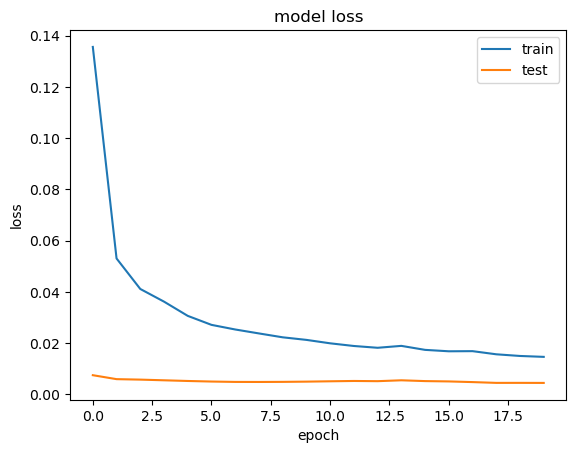

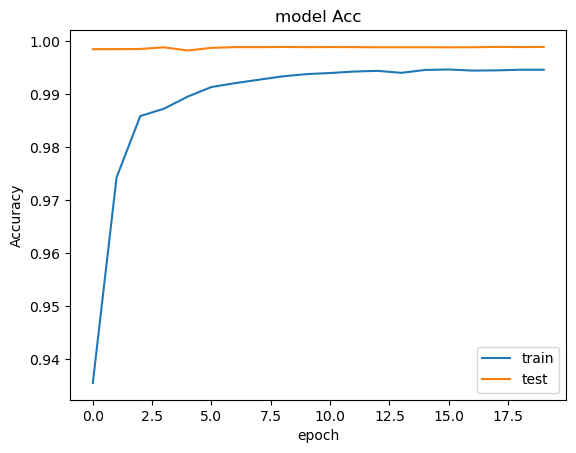

In [33]:
# TRAIN THE MODEL...
Train = True
inputshape_X = (train_X.shape)

if Train == True:
    model = LSTM_model_setup(inputshape_X)
    history = model.fit(train_X, [train_Y, train_Y_Hot], epochs = 20, batch_size = 32, validation_data = (val_X, [val_Y,val_Y_Hot]), shuffle = False)
    plot_training([history.history['class_out_loss'],history.history['val_class_out_loss']],
                  what = 'loss',
                  name = ('training_'+ str(Future)))
    plot_training([history.history['class_out_acc'],history.history['val_class_out_acc']],
                  what = 'acc',
                  name = ('training_'+ str(Future)))
    model.save('./model/Pump_LSTM_Fapi_4_' + str(Future) + '.h5')

# ...OR LOAD THE MODELl
else:
    model = tf.keras.models.load_model('./model/Pump_LSTM_Fapi')

From the model, we can summarize that there are two LSTM layers with each 42 hidden units and two output layers. The signal_out is a Dense layer with one unit giving us a predicted signal, while the class_out is a Dense layer with 3 units and softmax activation giving us the predicted classes “Normal”, “Recovering” and “Broken”.

625/625 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.60      0.97      0.74     11609
           2       0.73      0.11      0.19      8390

    accuracy                           0.61     20000
   macro avg       0.44      0.36      0.31     20000
weighted avg       0.65      0.61      0.51     20000

[[    0     0     1]
 [    0 11277   332]
 [    0  7497   893]]

Accuracy :  60.85  %
f1_score :  0.509


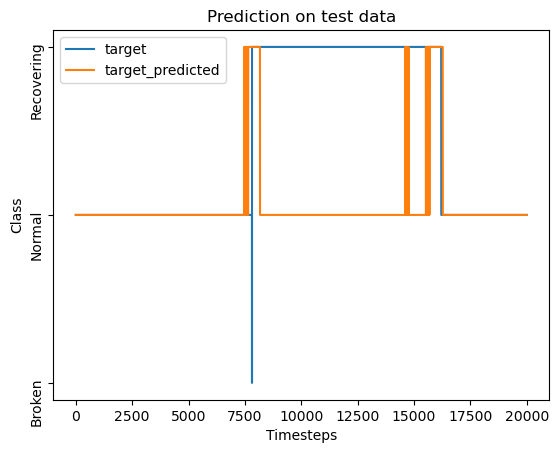

In [34]:
# INFERENCE
# make a prediction

[ysignal, yclass] = model.predict(test_X)
y_pred_classes = [np.argmax(yclass[i], axis=0) for i in range(len(yclass))]  # get final class

classification_report_output = classification_report(test_Y, y_pred_classes, zero_division=0)
print(classification_report_output)
# confusion matrix
matrix = confusion_matrix(test_Y, y_pred_classes)
print(matrix)

LSTM_f1 = round(f1_score(test_Y, y_pred_classes, average='weighted'), 3)
LSTM_accuracy = round((accuracy_score(test_Y, y_pred_classes)*100),2)

print(); print("Accuracy : " , LSTM_accuracy , " %")
print("f1_score : " , LSTM_f1)

# Plot predicted results
plot_predicted_results(y_pred_classes, test_Y)

The faulty episode is not directly classified. However, the recovering phase is detected quite well and, in this case, 10 min in advance. As an engineering problem, that is enough, as we positively detect the start and end of the faulty event and have time to react (switch off, transfer to another pump, lower speed, …).

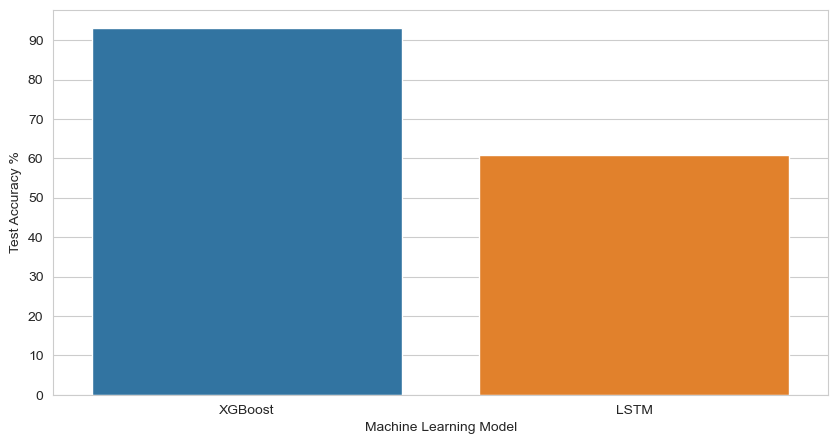

In [35]:
#Comparing the accuracy for XGBoost and LSTM models

model = ['XGBoost', 'LSTM']
acc = [xgb_accuracy, LSTM_accuracy]

sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Test Accuracy %")
plt.xlabel("Machine Learning Model")
sns.barplot(x= model, y= acc)
plt.show()

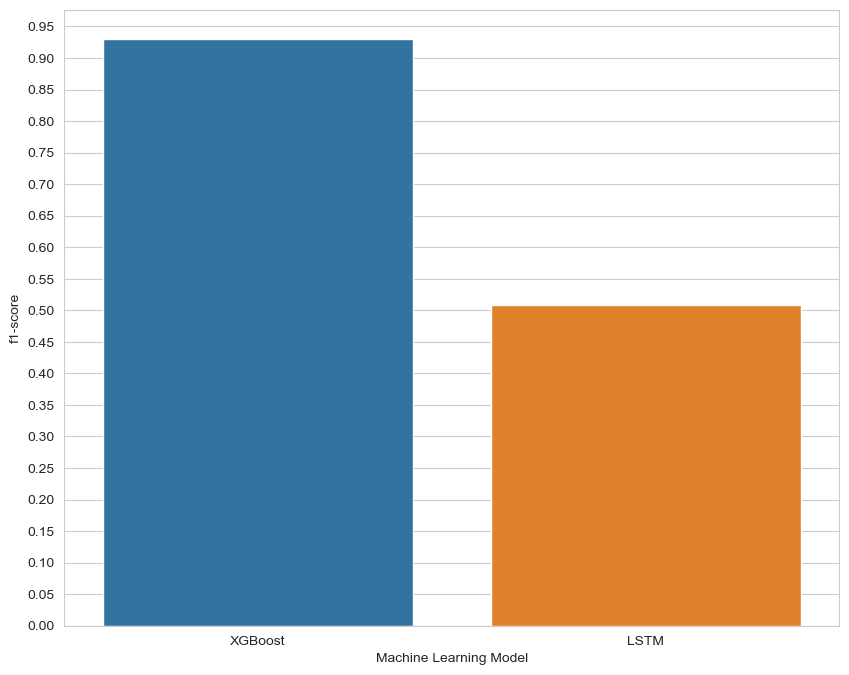

In [36]:
# Comparing the f1-score for XGBoost and LSTM models
model = ['XGBoost', 'LSTM']
f1_score = [xgb_f1, LSTM_f1]

sns.set_style("whitegrid")
plt.figure(figsize=(10,8))
plt.yticks(np.linspace(0,1,21))
plt.ylabel("f1-score")
plt.xlabel("Machine Learning Model")
sns.barplot(x= model,  y= f1_score)
plt.show()